# Creata GPR data

=> The figure is created in the notebook `GPR-Figure.ipynb`.

### Warning: SciPy 0.19.0 has a memory leak in quadpack. Use another version (newer or older)
The problem is already fixed from the scipy-devs, and will be in the next bugfix-release 0.19.1. Here I used the previous version 0.18.1.

In [1]:
import os
import scipy
import subprocess
import numpy as np
import matplotlib.pyplot as plt

from empyscripts import fdesign
from empymod.model import gpr, tem
from empymod.utils import printstartfinish

# Style adjustments
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['text.usetex'] = True  # Comment this if you don't have LaTeX. You might have to adjust some strings.
plt.rcParams['font.serif'] = 'Computer Modern Roman'
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.style'] = 'normal'

## Parameters
Parameters as in Hunziker et al., 2015

In [2]:
x = np.r_[0.001, np.arange(1, 201)*.02]     # X-coord from 0 to 4 m, spacing of 20 cm
y = np.zeros(x.size)                        # Y-coord = 0
zsrc = 0.0000001                            # Source depth just slightly below 0
zrec = 0.5                                  # Receiver depth at 0.5 m
depth = [0, 1]                              # 1 layer of 1 m thickness between two half-spaces
eperm = [1, 9, 15]                          # El. permit. model
res = [2e14, 200, 20]                       # Resistivity model: air, 1st layer, 2nd layer
f = np.arange(1, 1701)*1e6/2                # Frequencies from 1e6 Hz to 850 Hz, 1e6 Hz sampling
t = np.r_[0.001, np.arange(1, 321)]/4*1e-9  # Times from 1 ns to 80 ns, 4 samples per ns
cf = 250e6                                  # Center frequency
verb = 2                                    # Verbosity level

# Collect general input parameters
inp = {'src': [0, 0, zsrc], 'rec': [x, y, zrec], 'depth': depth, 'res': res, 'cf': cf, 'ab': 11,
       'gain': 3, 'epermH': eperm, 'epermV': eperm, 'loop': 'off', 'verb': verb, 'freqtime': t, 'opt': 'spline',
       'ft': 'fft', 'ftarg': [f[0], f.size, 4096]}  # FFT: we are padding with zerose to 2048 samples

## Calculate GPR with `empymod` for DLF, QWE, and QUAD

and store it in `*.npy`-files which are loaded in the `gpr-figures.ipynb`.

## 1. DLF

Note that DLF runs, unlike the other 3 methods, by default in parallel (Python does that, not me, and I am not sure why.)

In [3]:
gprDLF = gpr(ht='fht', htarg=fdesign.load_filter('wer2001'), **inp)
np.save('data/GPR-DLF', gprDLF)


:: empymod END; runtime = 0:02:09.850592 :: 1700 kernel call(s)



## 2. QWE

In [4]:
if scipy.__version__ == '0.19.0':
    print('SciPy 0.19.0 has a memory leak in QUAD, use another version!')
gprQWE = gpr(ht='qwe', htarg=[1e-8, 1e-15, '', 200, 200, 60, 1e-6, 160, 4000], **inp)
np.save('data/GPR-QWE', gprQWE)

* WARNING :: Hankel-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.

:: empymod END; runtime = 7:19:57.705837 :: 1700 kernel call(s)



## 3. QUAD

In [5]:
if scipy.__version__ == '0.19.0':
    print('SciPy 0.19.0 has a memory leak in QUAD, use another version!')
gprQUA = gpr(ht='quad', htarg=['', '', 51, '', 160, 500], **inp)
np.save('data/GPR-QUA', gprQUA)

* WARNING :: Hankel-quadrature did not converge at least once;
             => desired `atol` and `rtol` might not be achieved.

:: empymod END; runtime = 11:27:00.482484 :: 1700 kernel call(s)



## Calculate GPR with `EMmod`

To calculate the `EMmod`-result, `EMmod` must be installed and in the bash-PATH.

In [6]:
# We use the empymod-utility to measure execution time; get start time
tstart = printstartfinish(verb)

# Change directory
os.chdir('data/GPR')

# Run EMmod
subprocess.run('bash gprloop_twointerface.scr', shell=True, stderr=subprocess.STDOUT, stdout=subprocess.PIPE)

# Change back to original directory
os.chdir('../..')

# Read data
fEM = np.zeros((f.size, x.size), dtype=complex)
for i in range(f.size):
    filename = 'data/GPR/gprloop_twointmod_freq'+str(int(f[i]))+'_11.bin'
    tf = open(filename, 'rb')
    temp = np.fromfile(tf)
    fEM[i, :] = temp[x.size*2:x.size*4:2] + 1j*temp[x.size*2+1:x.size*4+1:2]

# Multiply with ricker wavelet
cfc = -(np.r_[0, f[:-1]]/250e6)**2
fwave = cfc*np.exp(cfc)
fEM *= fwave[:, None]

# Do f->t transform
tEM, conv = tem(fEM, x, f, t, 0, 'fft', [f[0], f.size, 4096, None])

# Apply gain; make pure real
tEM *= (1 + np.abs((t*10**9)**3))[:, None]
gprEMmod = tEM.real

# Print execution time (it will show 'empymod', but obviously in this case it is `EMmod`)
printstartfinish(verb, tstart)

# Store EMmod
np.save('data/GPR-EMmod', gprEMmod)


:: empymod END; runtime = 18:54:31.546724 :: 



## Calculate theoretical arrival times

In [7]:
# Arrival times for direct wave
clight = 299792458
vel = clight/np.sqrt(eperm[1])
arrtime = np.sqrt((zsrc-zrec)**2 + x**2 + y**2)/vel

# Arrival times for reflected wave
arrtimeref = np.sqrt((np.abs(zsrc - depth[1]) + np.abs(zrec - depth[1]))**2 + x**2 + y**2)/vel

# Arrival times for refracted wave in the air
# This only works if ypos = 0
refractang = np.arcsin(vel/clight)
arrtimerefair = (np.abs(zsrc - depth[0])/np.cos(refractang) + np.abs(zrec - depth[0])/np.cos(refractang))/vel
arrtimerefair += (np.abs(x) - np.abs(zsrc - depth[0])*np.tan(refractang) - np.abs(zrec - depth[0])*np.tan(refractang))/clight

np.savez('data/ArrivalTimes.npz', arrtime=arrtime, arrtimeref=arrtimeref, arrtimerefair=arrtimerefair, x=x)

## Comparison plot

In [8]:
# 1. EMmod
gprEMM = np.load('data/GPR-EMmod.npy')

# 2. QUA
gprQUA = np.load('data/GPR-QUA.npy')

# 3. QWE
gprQWE = np.load('data/GPR-QWE.npy')

# 4. DLF
gprDLF = np.load('data/GPR-DLF.npy')

# 3. Arrival times
x = np.load('data/ArrivalTimes.npz')['x']
arrtime = np.load('data/ArrivalTimes.npz')['arrtime']
arrtimeref = np.load('data/ArrivalTimes.npz')['arrtimeref']
arrtimerefair = np.load('data/ArrivalTimes.npz')['arrtimerefair']

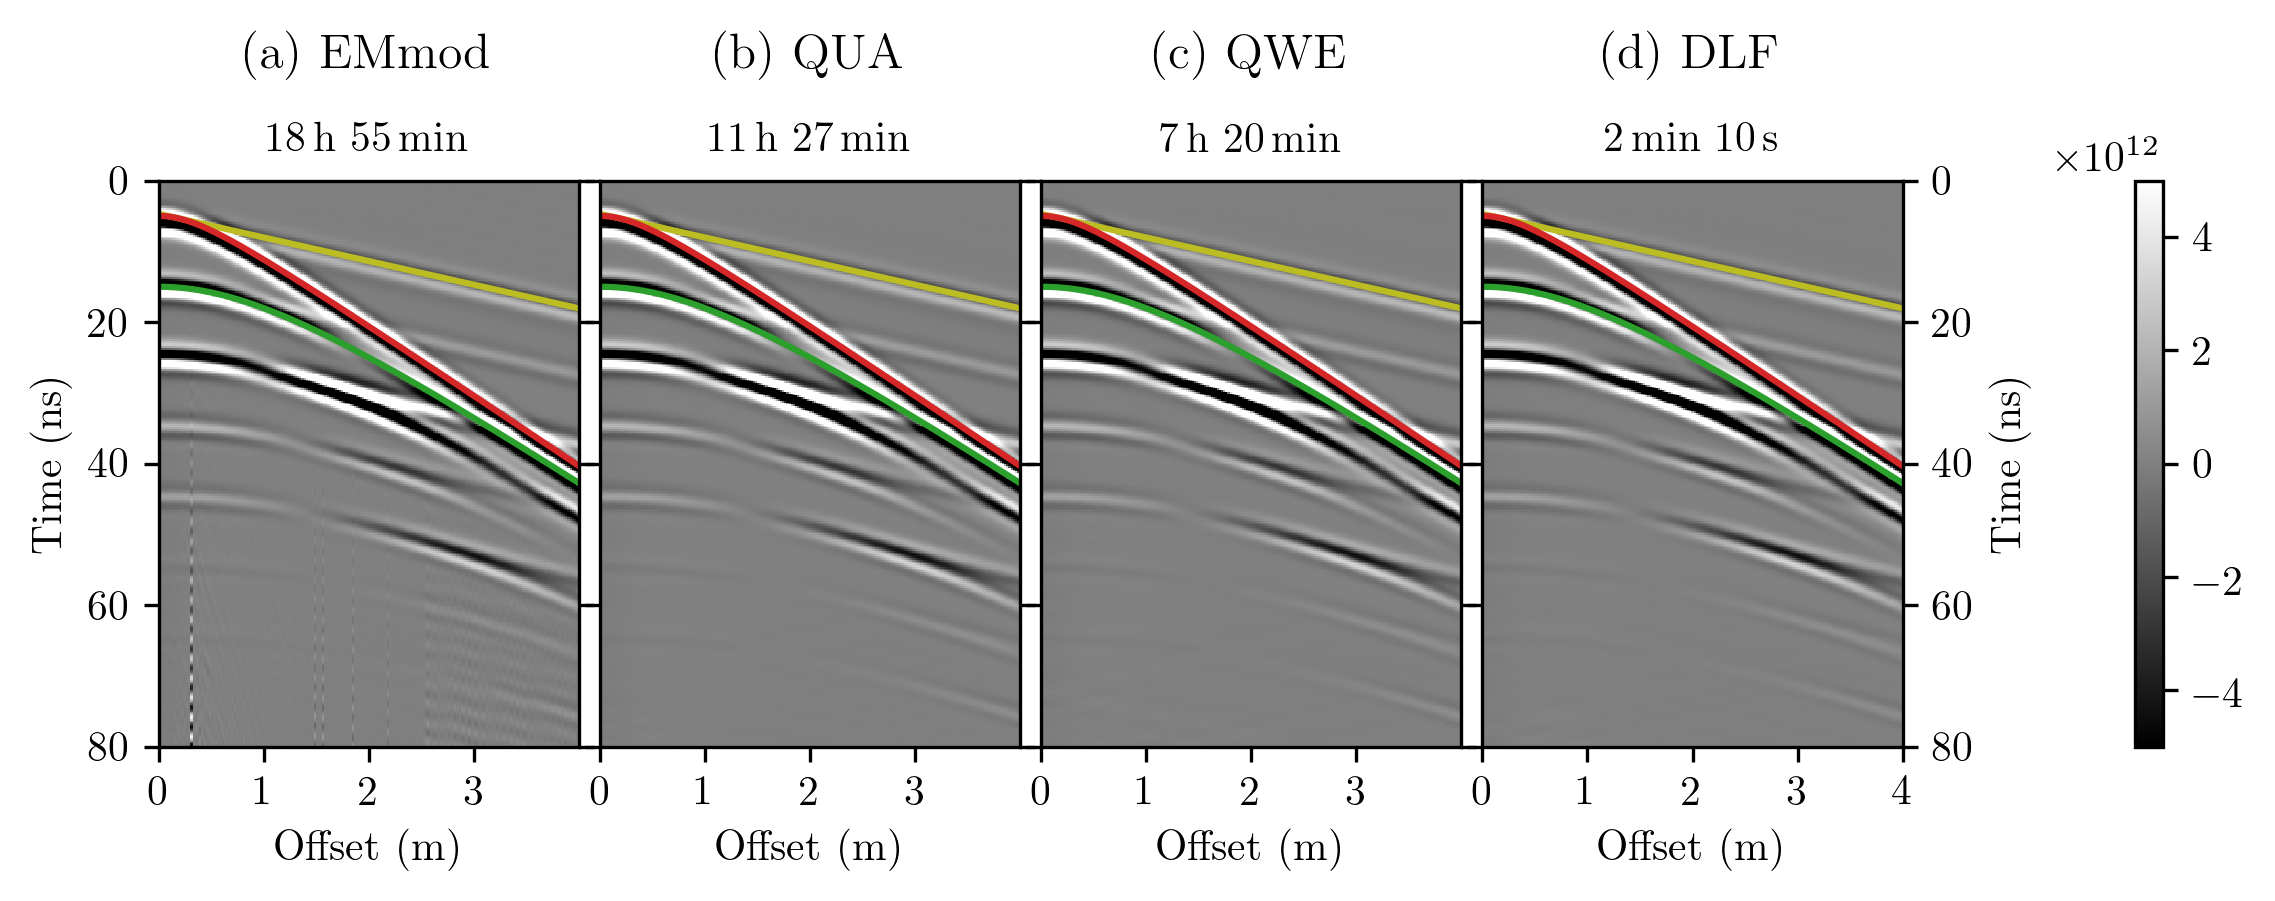

In [9]:
fig, axs = plt.subplots(figsize=(10, 2.5), facecolor = 'w', nrows=1, ncols=4)
fig.subplots_adjust(wspace=.05)
axs = axs.ravel() 

# # Plot GPR result # #
params = {'cmap':'gray', 'vmin':-5*10**12, 'vmax':5*10**12,
          'extent':[0, 4, 80, 0], 'aspect':'auto'}

# Set axis and limits
def limits(i):
    plt.sca(axs[i])
    ax = plt.gca()
    if i in [1, 2]:
        ax.set_yticklabels([], ())
    ax.yaxis.set_ticks_position('both')
    plt.plot(x, arrtimerefair*10**9, 'C8', lw=1.5)
    plt.plot(x, arrtime*10**9, 'C3', lw=1.5)
    plt.plot(x, arrtimeref*10**9, 'C2', lw=1.5)
    plt.ylim([80, 0])
    plt.xlim([0, 4])
    plt.xlabel('Offset (m)')
    plt.xticks(np.arange(4))
    plt.grid('off')
    return ax

# Plot EMM
ax = limits(0)
plt.text(0.5, 1.2, r'(a) EMmod', transform=ax.transAxes, horizontalalignment='center', fontsize=12)
plt.text(0.5, 1.05, r'18\,h 55\,min', transform=ax.transAxes, horizontalalignment='center')
plt.imshow(gprEMM, **params)
plt.ylabel('Time (ns)')

# Plot QUA
ax = limits(1)
plt.text(0.5, 1.2, r'(b) QUA', transform=ax.transAxes, horizontalalignment='center', fontsize=12)
plt.text(0.5, 1.05, r'11\,h 27\,min', transform=ax.transAxes, horizontalalignment='center')
plt.imshow(gprQUA, **params)

# Plot QWE
ax = limits(2)
plt.text(0.5, 1.2, r'(c) QWE', transform=ax.transAxes, horizontalalignment='center', fontsize=12)
plt.text(0.5, 1.05, r'7\,h 20\,min', transform=ax.transAxes, horizontalalignment='center')
plt.imshow(gprQWE, **params)

# Plot DLF
ax = limits(3)
plt.text(0.5, 1.2, r'(d) DLF', transform=ax.transAxes, horizontalalignment='center', fontsize=12)
plt.text(0.5, 1.05, r'2\,min 10\,s', transform=ax.transAxes, horizontalalignment='center')
plt.imshow(gprDLF, **params)

plt.xticks(np.arange(5))
ax.yaxis.set_ticks_position('right')
ax.yaxis.set_label_position('right')
plt.ylabel('Time (ns)')
ax.yaxis.set_ticks_position('both')

# Plot colorbar
cax, kw = plt.matplotlib.colorbar.make_axes([axs[0], axs[1], axs[2], axs[3]], pad=0.1)
cb = plt.colorbar(cax=cax, **kw)

# Save figure and show it
plt.savefig('../figures/GPR-comp.pdf', bbox_inches='tight')
plt.show()

In [10]:
from empyscripts import versions
versions('HTML')